In [1]:
# --- 1. Setup Environment ---
!pip uninstall -y jax jaxlib tensorflow flax -q
!pip install -U transformers datasets evaluate accelerate codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 90.4 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 44.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 94.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:0

In [2]:
# --- 2. Imports ---
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DistilBertConfig,
    DistilBertForSequenceClassification
)
from codecarbon import EmissionsTracker

In [3]:
# --- 3. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [4]:
# --- 4. Load IMDB Dataset ---
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

full_train_dataset = tokenized_datasets["train"]
full_test_dataset = tokenized_datasets["test"]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# --- 5. Define Metrics ---
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

## Baseline DistilBERT

In [7]:
# --- Baseline ---
model_checkpoint = "distilbert-base-uncased"
model_baseline = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

training_args_base = TrainingArguments(
    output_dir="./results_baseline",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs_baseline",
    logging_steps=50,
    report_to="none"
)

trainer_base = Trainer(
    model=model_baseline,
    args=training_args_base,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_base = EmissionsTracker(output_file="emissions_baseline.csv")
tracker_base.start()
trainer_base.train()
baseline_results = trainer_base.evaluate()
tracker_base.stop()

# Save results
pd.DataFrame([{
    "Experiment": "Baseline",
    "Accuracy": baseline_results["eval_accuracy"],
    "Validation Loss": baseline_results["eval_loss"]
}]).to_csv("results_baseline.csv", index=False)

print("Baseline Accuracy:", baseline_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/3216487843.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_base = Trainer(
[codecarbon WARNING @ 12:20:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:20:57] [setup] RAM Tracking...
[codecarbon INFO @ 12:20:57] [setup] CPU Tracking...
[codecarbon WARNING @ 12:20:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:20:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux

Epoch,Training Loss,Validation Loss,Accuracy
1,0.250600,0.241062,0.900920
2,0.144700,0.256961,0.909600
3,0.126900,0.276052,0.912120


[codecarbon INFO @ 12:21:17] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:21:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 12:21:17] Energy consumed for all GPUs : 0.000496 kWh. Total GPU Power : 119.08091087167719 W
[codecarbon INFO @ 12:21:17] 0.000757 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:32] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:21:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:21:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:21:32] Energy consumed for all GPUs : 0.001035 kWh. Total GPU Power : 129.24614356183002 W
[codecarbon INFO @ 12:21:32] 0.001556 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:21:47] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 12:44:02] Energy consumed for RAM : 0.007661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:44:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:02] Energy consumed for All CPU : 0.016281 kWh
[codecarbon INFO @ 12:44:02] Energy consumed for all GPUs : 0.049207 kWh. Total GPU Power : 129.36641369675874 W
[codecarbon INFO @ 12:44:02] 0.073148 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:17] Energy consumed for RAM : 0.007744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:44:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:17] Energy consumed for All CPU : 0.016458 kWh
[codecarbon INFO @ 12:44:17] Energy consumed for all GPUs : 0.049748 kWh. Total GPU Power : 129.98110976435711 W
[codecarbon INFO @ 12:44:17] 0.073950 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:44:32] Energy consumed for RAM : 0.007827 kWh. RAM Power :

Baseline Accuracy: 0.91212


## FP16 Mixed Precision

In [8]:
training_args_fp16 = TrainingArguments(
    output_dir="./results_fp16",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs_fp16",
    logging_steps=50,
    report_to="none",
    fp16=True
)

model_fp16 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer_fp16 = Trainer(
    model=model_fp16,
    args=training_args_fp16,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_fp16 = EmissionsTracker(output_file="emissions_fp16.csv")
tracker_fp16.start()
trainer_fp16.train()
fp16_results = trainer_fp16.evaluate()
tracker_fp16.stop()

pd.DataFrame([{
    "Experiment": "FP16 Mixed Precision",
    "Accuracy": fp16_results["eval_accuracy"],
    "Validation Loss": fp16_results["eval_loss"]
}]).to_csv("results_fp16.csv", index=False)

print("FP16 Accuracy:", fp16_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/2608306175.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fp16 = Trainer(
[codecarbon WARNING @ 12:45:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:45:43] [setup] RAM Tracking...
[codecarbon INFO @ 12:45:43] [setup] CPU Tracking...
[codecarbon WARNING @ 12:45:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 12:45:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux

Epoch,Training Loss,Validation Loss,Accuracy
1,0.243900,0.233333,0.903280
2,0.143700,0.259273,0.910280
3,0.117600,0.273521,0.910960


[codecarbon INFO @ 12:46:02] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:46:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:02] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 12:46:02] Energy consumed for all GPUs : 0.000526 kWh. Total GPU Power : 126.14306975771733 W
[codecarbon INFO @ 12:46:02] 0.000786 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:17] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 12:46:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:46:17] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 12:46:17] Energy consumed for all GPUs : 0.001058 kWh. Total GPU Power : 127.78703475084203 W
[codecarbon INFO @ 12:46:17] 0.001578 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:46:32] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 13:08:47] Energy consumed for RAM : 0.007661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:08:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:08:47] Energy consumed for All CPU : 0.016281 kWh
[codecarbon INFO @ 13:08:47] Energy consumed for all GPUs : 0.049211 kWh. Total GPU Power : 129.81849374492822 W
[codecarbon INFO @ 13:08:47] 0.073153 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:09:02] Energy consumed for RAM : 0.007744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:09:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:09:02] Energy consumed for All CPU : 0.016458 kWh
[codecarbon INFO @ 13:09:02] Energy consumed for all GPUs : 0.049752 kWh. Total GPU Power : 129.87009078666483 W
[codecarbon INFO @ 13:09:02] 0.073954 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:09:17] Energy consumed for RAM : 0.007827 kWh. RAM Power :

FP16 Accuracy: 0.91096


## Label Smoothing

In [9]:
import torch
from torch.nn import Module
from transformers import Trainer

class LabelSmoothingLoss(Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(-1)
        with torch.no_grad():
            smooth_labels = torch.full_like(logits, self.smoothing / (num_classes - 1))
            smooth_labels.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-smooth_labels * torch.nn.functional.log_softmax(logits, dim=-1), dim=-1))

class LSTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = LabelSmoothingLoss()(logits, labels)
        return (loss, outputs) if return_outputs else loss

model_ls = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

trainer_ls = LSTrainer(
    model=model_ls,
    args=training_args_fp16,  # reuse fp16 args for speed
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_ls = EmissionsTracker(output_file="emissions_ls.csv")
tracker_ls.start()
trainer_ls.train()
ls_results = trainer_ls.evaluate()
tracker_ls.stop()

pd.DataFrame([{
    "Experiment": "Label Smoothing",
    "Accuracy": ls_results["eval_accuracy"],
    "Validation Loss": ls_results["eval_loss"]
}]).to_csv("results_ls.csv", index=False)

print("Label Smoothing Accuracy:", ls_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/861193573.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `LSTrainer.__init__`. Use `processing_class` instead.
  trainer_ls = LSTrainer(
[codecarbon WARNING @ 13:10:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:10:39] [setup] RAM Tracking...
[codecarbon INFO @ 13:10:39] [setup] CPU Tracking...
[codecarbon WARNING @ 13:10:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:10:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linu

Epoch,Training Loss,Validation Loss,Accuracy
1,0.438800,0.434357,0.903640
2,0.390500,0.436806,0.908520
3,0.378100,0.438584,0.911920


[codecarbon INFO @ 13:10:58] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:10:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:10:58] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 13:10:58] Energy consumed for all GPUs : 0.000526 kWh. Total GPU Power : 126.09748832575326 W
[codecarbon INFO @ 13:10:58] 0.000786 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:13] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:11:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:11:13] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 13:11:13] Energy consumed for all GPUs : 0.001058 kWh. Total GPU Power : 127.92046098885676 W
[codecarbon INFO @ 13:11:13] 0.001579 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:11:28] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 13:33:58] Energy consumed for RAM : 0.007744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:33:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:33:58] Energy consumed for All CPU : 0.016458 kWh
[codecarbon INFO @ 13:33:58] Energy consumed for all GPUs : 0.049738 kWh. Total GPU Power : 129.86812277583738 W
[codecarbon INFO @ 13:33:58] 0.073939 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:13] Energy consumed for RAM : 0.007827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:34:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:34:13] Energy consumed for All CPU : 0.016635 kWh
[codecarbon INFO @ 13:34:13] Energy consumed for all GPUs : 0.050279 kWh. Total GPU Power : 129.9634208057466 W
[codecarbon INFO @ 13:34:13] 0.074741 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:28] Energy consumed for RAM : 0.007911 kWh. RAM Power : 

Label Smoothing Accuracy: 0.91192


## Increased Dropout

In [10]:
config = DistilBertConfig.from_pretrained(model_checkpoint)
config.dropout = 0.2
config.attention_dropout = 0.2

model_dropout = DistilBertForSequenceClassification.from_pretrained(
    model_checkpoint,
    config=config
)

trainer_dropout = Trainer(
    model=model_dropout,
    args=training_args_fp16,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

tracker_dropout = EmissionsTracker(output_file="emissions_dropout.csv")
tracker_dropout.start()
trainer_dropout.train()
dropout_results = trainer_dropout.evaluate()
tracker_dropout.stop()

pd.DataFrame([{
    "Experiment": "Increased Dropout",
    "Accuracy": dropout_results["eval_accuracy"],
    "Validation Loss": dropout_results["eval_loss"]
}]).to_csv("results_dropout.csv", index=False)

print("Increased Dropout Accuracy:", dropout_results["eval_accuracy"])


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/1482005782.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_dropout = Trainer(
[codecarbon WARNING @ 13:35:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:35:35] [setup] RAM Tracking...
[codecarbon INFO @ 13:35:35] [setup] CPU Tracking...
[codecarbon WARNING @ 13:35:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:35:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Li

Epoch,Training Loss,Validation Loss,Accuracy
1,0.243500,0.235798,0.904600
2,0.186600,0.238007,0.910680
3,0.170900,0.246435,0.913120


[codecarbon INFO @ 13:35:55] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:35:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:35:55] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 13:35:55] Energy consumed for all GPUs : 0.000527 kWh. Total GPU Power : 126.42819650360143 W
[codecarbon INFO @ 13:35:55] 0.000788 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:10] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:36:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:36:10] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 13:36:10] Energy consumed for all GPUs : 0.001059 kWh. Total GPU Power : 127.72943131800113 W
[codecarbon INFO @ 13:36:10] 0.001580 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:36:25] Energy consumed for RAM : 0.000250 kWh. RAM Power :

[codecarbon INFO @ 13:58:40] Energy consumed for RAM : 0.007661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:58:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:58:40] Energy consumed for All CPU : 0.016281 kWh
[codecarbon INFO @ 13:58:40] Energy consumed for all GPUs : 0.049193 kWh. Total GPU Power : 129.3789520599771 W
[codecarbon INFO @ 13:58:40] 0.073135 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:55] Energy consumed for RAM : 0.007744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:58:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:58:55] Energy consumed for All CPU : 0.016458 kWh
[codecarbon INFO @ 13:58:55] Energy consumed for all GPUs : 0.049736 kWh. Total GPU Power : 130.31794600404484 W
[codecarbon INFO @ 13:58:55] 0.073938 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:10] Energy consumed for RAM : 0.007827 kWh. RAM Power : 

Increased Dropout Accuracy: 0.91312


## Results (Accuracy and Energy Consumption)

In [23]:
import pandas as pd

# --- Files from your experiments ---
results_files = {
    "Baseline": ("results_baseline.csv", "emissions_baseline.csv"),
    "FP16 Mixed Precision": ("results_fp16.csv", "emissions_fp16.csv"),
    "Label Smoothing": ("results_ls.csv", "emissions_ls.csv"),
    "Increased Dropout": ("results_dropout.csv", "emissions_dropout.csv"),
}

print(f"{'Experiment':<25} {'Accuracy':<10} {'Energy (kg CO2)':<15}")
print("-" * 55)

for exp_name, (res_file, energy_file) in results_files.items():
    res_df = pd.read_csv(res_file)
    energy_df = pd.read_csv(energy_file)
    
    accuracy = res_df.loc[0, "Accuracy"]
    energy = energy_df["emissions"].sum()
    
    print(f"{exp_name:<25} {accuracy:<10.4f} {energy:<15.6f}")


Experiment                Accuracy   Energy (kg CO2)
-------------------------------------------------------
Baseline                  0.9121     0.035540       
FP16 Mixed Precision      0.9135     0.034800       
Label Smoothing           0.9119     0.035814       
Increased Dropout         0.9131     0.035769       


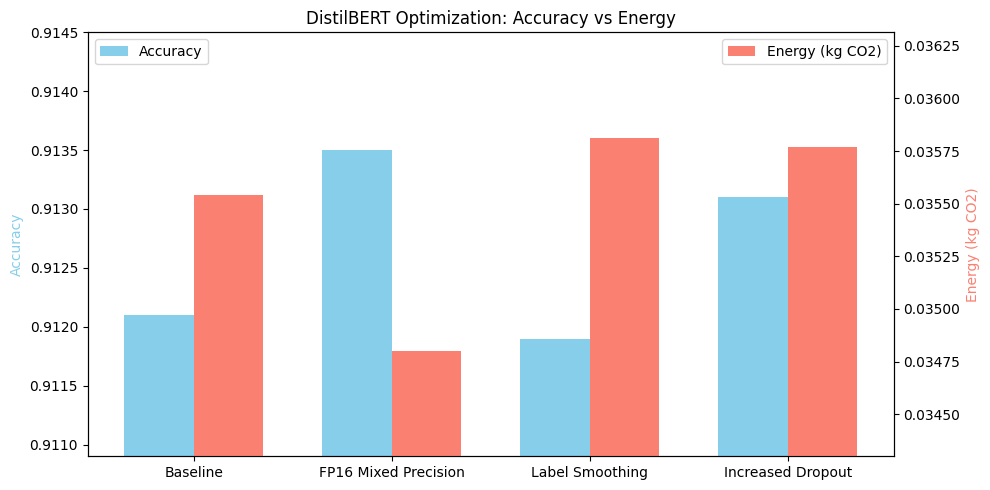

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load results ---
results_files = {
    "Baseline": ("results_baseline.csv", "emissions_baseline.csv"),
    "FP16 Mixed Precision": ("results_fp16.csv", "emissions_fp16.csv"),
    "Label Smoothing": ("results_ls.csv", "emissions_ls.csv"),
    "Increased Dropout": ("results_dropout.csv", "emissions_dropout.csv"),
}

experiments = []
accuracies = []
energies = []

for exp_name, (res_file, energy_file) in results_files.items():
    res_df = pd.read_csv(res_file)
    energy_df = pd.read_csv(energy_file)
    
    experiments.append(exp_name)
    accuracies.append(res_df.loc[0, "Accuracy"])
    energies.append(energy_df["emissions"].sum())

x = np.arange(len(experiments))
width = 0.4

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Accuracy
ax1.bar(x - width/2, accuracies, width, color='skyblue')
ax1.set_ylabel('Accuracy (Skyblue)', color='skyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_ylim(min(accuracies) - 0.005, max(accuracies) + 0.01)  # zoom in on accuracy range

ax1.set_xticks(x)
ax1.set_xticklabels(experiments, rotation=20, ha='right')

# Plot Energy on secondary y-axis
ax2 = ax1.twinx()
ax2.bar(x + width/2, energies, width, color='salmon')
ax2.set_ylabel('Energy (kg CO2) (Salmon)', color='salmon', fontsize=12)
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_ylim(min(energies) - 0.002, max(energies) + 0.002)  # zoom in on energy range

# Title
plt.title("IMDB Sentiment Classification: Accuracy vs Energy per Experiment", fontsize=14)
plt.tight_layout()
plt.show()
